# Final Exam - Open

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

* Name: Jose Luna 
* Disclaimer: I used my own code and also utilized GPT for syntax and editing corrections.

***

# Instructions

## Please note the following:

Points
* The exam is `85` points.
* You have `85` minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.


Submission
* You will upload your solution to the `Final - Open` assignment on Canvas, where you downloaded this. 
* Be sure to **submit** on Canvas, not just **save** on Canvas.
* Your submission should be readable, (the graders can understand your answers.)
* Your submission should **include all code used in your analysis in a file format that the code can be executed.** 

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo - you are welcome to use the code posted there without citation.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

- For Section 1:
    * `data/final_exam_data.xlsx`
- for Section 2:
    * `data/fx_rf_data.xlsx`

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 40     |
| 2       | 45     |

### Each numbered question is worth 5 points unless otherwise specified.

***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew,kurtosis,norm
import statsmodels.api as sm

In [2]:
path = "../data/final_exam_data.xlsx"
Asset_Returns = pd.read_excel(path, sheet_name="Asset Returns", index_col=0)
Factor_Returns = pd.read_excel(path, sheet_name="Factor Returns", index_col=0)
Asset_Betas = pd.read_excel(path, sheet_name="Asset Betas", index_col=0)

In [ ]:
def get_metric_returns(returns, weights=[], adj_factor=12, VaR_q=5):


    if len(weights) == 0:
        port_metrics = returns.copy()
    else:
        port_metrics = returns @ weights
        port_metrics = pd.DataFrame(port_metrics, columns=['Portfolio'])

    result = pd.DataFrame()

    if len(weights) == 0:
        port_metrics_r = pd.DataFrame({
            "Mean": port_metrics.mean() * adj_factor,
            "Volatility": port_metrics.std() * np.sqrt(adj_factor)
        })
        port_metrics_r["Sharpe_Ratio"] = (port_metrics.mean() / port_metrics.std()) * np.sqrt(adj_factor)
        port_metrics_r["Skew"] = port_metrics.apply(skew)
        port_metrics_r["Excess Kurtosis"] = port_metrics.apply(kurtosis, fisher=True, bias=False)
    else:
        asset = 'Portfolio'
        port_metrics_r = pd.DataFrame({
            "Mean": [port_metrics[asset].mean() * adj_factor],
            "Volatility": [port_metrics[asset].std() * np.sqrt(adj_factor)]
        }, index=[asset])
        port_metrics_r["Sharpe_Ratio"] = (port_metrics[asset].mean() / port_metrics[asset].std()) * np.sqrt(adj_factor)
        port_metrics_r["Skew"] = skew(port_metrics[asset])
        port_metrics_r["Excess Kurtosis"] = kurtosis(port_metrics[asset], fisher=True, bias=False)

    for asset in port_metrics.columns:
        data_aux = port_metrics[[asset]].copy()
        VaR = np.percentile(sorted(data_aux.values.flatten()), q=VaR_q)
        CVaR = data_aux[data_aux[asset] <= VaR].mean().values[0]

        data_aux_acum_return = (data_aux + 1).cumprod()
        data_aux_max_cum_return = data_aux_acum_return.cummax()
        data_aux_drawdown = ((data_aux_acum_return - data_aux_max_cum_return) / data_aux_max_cum_return)
        max_drawdown = data_aux_drawdown.min().values[0]
        max_drawdown_date = data_aux_drawdown.idxmin().values[0]
        peak_idx = data_aux_max_cum_return.idxmax().values[0]
        recovery_data = data_aux_drawdown[data_aux_drawdown.index >= max_drawdown_date]
        recovery_idx = recovery_data[recovery_data[asset] >= -0.00001].first_valid_index()
        duration = (recovery_idx - max_drawdown_date).days if recovery_idx else np.nan

        aux_result = pd.DataFrame(
            [[VaR, CVaR, max_drawdown, max_drawdown_date, peak_idx, recovery_idx, duration]],
            columns=["VaR", "CVaR", "Max Drawdown", "Bottom", "Peak", "Recovery", "Duration (days)"],
            index=[asset]
        )
        result = pd.concat([result, aux_result], axis=0)

    metrics = pd.merge(port_metrics_r, result, left_index=True, right_index=True, how="left")
    return metrics

# 1. Cross-Sectional Factor Pricing

Use the data found in the file `final_data.xlsx`. The sheet named `Asset Returns` contains daily excess returns data for various assets; the sheet named `Factor Returns` contains daily excess returns data for some unknown factor; and the sheet named `Asset Betas` contains the betas of each asset with respect to the given factor.

Consider the data to have an annualization factor of `252` days per year.

### 1.
(10pts)

Using linear regression, estimate the factor risk premium for __each point in time__, using the following model: $\phantom{Brian Hood}$ 

$$
\tilde{r}^{(i)}_t = \beta^{(i)}\lambda_t + \epsilon^{(i)}_t
$$

Using your estimated series $\lambda_t$, report...

* the last 3 values. 

* the annualized mean.

* the annualized vol.

In [50]:
betas = Asset_Betas.squeeze() 
betas_array = betas.values.reshape(-1, 1)

lambda_estimates = []

for date in Asset_Returns.index:
    r_t = Asset_Returns.loc[date].values
    model = sm.OLS(r_t, betas_array).fit()
    
    lambda_t = model.params[0]
    lambda_estimates.append(lambda_t)

lambda_t_series = pd.Series(lambda_estimates, index=Asset_Returns.index, name='lambda_t')

In [49]:
print("Last 3 values of lambda_t:\n", lambda_t_series.tail(3))


Last 3 values of lambda_t:
 Date
2024-11-06    0.022971
2024-11-07    0.001064
2024-11-08    0.001768
Name: lambda_t, dtype: float64


In [51]:
annual_factor = 252
annual_mean = lambda_t_series.mean() * annual_factor
print("Annualized Mean of λ_t:", annual_mean)

# Annualized volatility
annual_vol = lambda_t_series.std() * np.sqrt(annual_factor)
print("Annualized Volatility of λ_t:", annual_vol)

Annualized Mean of λ_t: 0.1754874142533425
Annualized Volatility of λ_t: 0.11688953313031768


### 2.

(10pts)

Compare $\lambda_t$ to the realized factor returns, $\tilde{f}_t$.

* Plot the cumulative (excess) returns of $\lambda_t$ and $\tilde{f}_t$.
* Report the correlation between these two series.
* Report the serial correlation of each series.

Should we expect the serial correlation of $\tilde{f}$ to be near zero? What about $\lambda_t$?

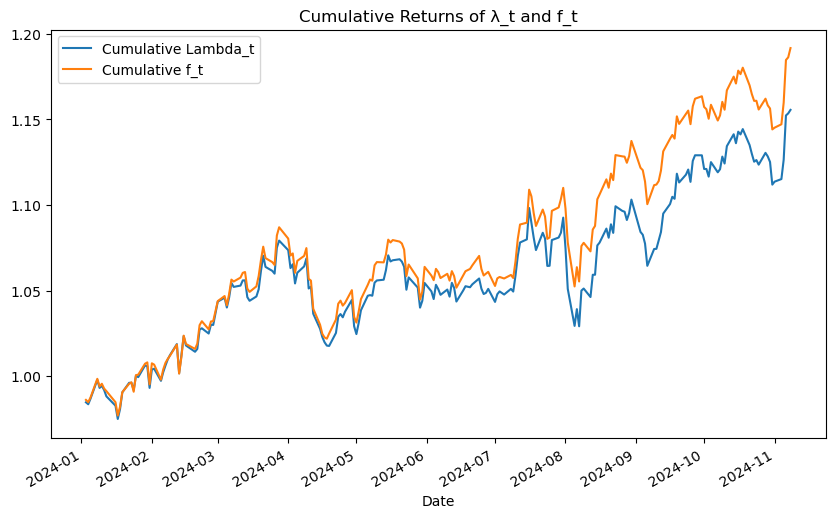

In [61]:
import matplotlib.pyplot as plt

f = Factor_Returns.squeeze().rename("f")

cum_lambda = (1 + lambda_t_series).cumprod()
cum_f = (1 + f).cumprod()

plt.figure(figsize=(10,6))
cum_lambda.plot(label='Cumulative Lambda_t')
cum_f.plot(label='Cumulative f_t')
plt.title("Cumulative Returns of λ_t and f_t")
plt.legend()
plt.show()

In [62]:
corr = lambda_t_series.corr(f)
print("Correlation between lambda_t and f_t:", corr)

Correlation between lambda_t and f_t: 0.9851319641635841


In [63]:
lambda_acorr = lambda_t_series.autocorr(lag=1)
f_acorr = f.autocorr(lag=1)

print("Serial correlation of lambda_t:", lambda_acorr)
print("Serial correlation of f_t:", f_acorr)

Serial correlation of lambda_t: 0.0015639909104252525
Serial correlation of f_t: 0.018437949835348768


*Answer* : 

We should expect that the serial correlation should be close to zero if the factor was constructed was FF factors or just like an market factor (returns), usually returns of assets/factor don't have a autocorrelation

On the other hand, for lambda t, if it is capable to replicate the factor should have a low autocorrelation, as we can see in the results, but in general if we construct from a cross-sectiona regression, it might not necessarily expect zero 

### 3.

We estimated our factor premium in a regression that excluded an intercept term. Why might we have done this? In what circumstance would we prefer to include an intercept term?

*Anwer* : 

The reason is that we're trying to extract the factor risk premium, lambda t, directly from the cross-section of returns using known betas. Including an intercept would absorb a common level effect across all assets, potentially biasing the estimate of lambda t.
  
We prefer to include an intercept when testing the model specification (e.g., to check if the pricing is accurate or if there is an abnormal return not explained by the factor). In theory, a perfect factor model does not require an intercept because alpha should be zero, and the expected value of the error should also be zero.

### 4.

(10pts)

Now, use the actual factor returns, $\tilde{f}_t$ to analyze the fit of this pricing model using a __single__ cross-sectional regression to estimate  $\phantom{Brian Hood}$

$$
E[r^{(i)}] = \eta + \beta^{(i)} E[\tilde{f}] + \epsilon^{(i)}
$$

How well does this factor work for pricing? Provide supporting evidence for your answer.

In [72]:
mean_asset_returns = Asset_Returns.mean(axis=0) * annual_factor

mean_factor_return = f.mean() * annual_factor

X = sm.add_constant(Asset_Betas.values) 
y = mean_asset_returns.values           

model = sm.OLS(y, X).fit()
print("Summary of the regression model:")
print("Intercept eta (annualized)", model.params[0])
print("Beta", model.params[1])
print("R-squared", model.rsquared)

print("Annualized Mean of the factor return:", mean_factor_return)

Summary of the regression model:
Intercept eta (annualized) 0.20010744342990833
Beta 0.011084283974322555
R-squared 0.00030916453633444974
Annualized Mean of the factor return: 0.21119172740423076


*Answer:*

Given that we are estimating a cross-sectional regresion, we expect a high  R-Squared and a (close) zero intercept, in this case the R-Square is very low 0.000309 and the instercept (Eta) is high (0.20), indicading this factors performances bad 

### 5.

The factor we've used, $\tilde{f}$ is actually the **equally**-weighted portfolio of equities. Suppose the CAPM holds exactly, with the **value**-weighted market equity portfolio. In that case, what would we expect, theoretically, from the previous section?

*Answer* :

If the CAPM holds exactly with the value-weighted market portfolio, then using an equally-weighted portfolio as the factor  should not, in theory, perfectly price assets in a cross-sectional regression. The equally-weighted portfolio is not the true market factor as per CAPM theory.
Now if CAPM holds with value weighted the cross sectional regression should have zero intercept, high R-Squared and the slope should be the market premium 
Since we are using an equally-weighted factor and the CAPM assumes the value-weighted market portfolio, we should not be surprised if the pricing model doesn't work perfectly.

***

In [16]:
path = "../data/fx_rf_data.xlsx"
risk_free_rate = pd.read_excel(path, sheet_name="risk-free rates", index_col=0)
exchange_rate = pd.read_excel(path, sheet_name="exchange rates", index_col=0)

# 2. Currency Trades

For this question, use the data set from `data/fx_rf_data.xlsx`.

Calculate the **arithmetic** (not log) excess return to holding each foreign currency.

Data Note:
* Consider the risk-free rate data as being quoted as an annualized value, where this annualization is a scaling of `252`.

Throughout this problem, we only consider returns generated between `Jan 2018` and `Aug 2024`.

In [17]:
risk_free_rate = risk_free_rate[(risk_free_rate.index >= "2018-01-01")&(risk_free_rate.index <= "2024-08-31")]
exchange_rate = exchange_rate[(exchange_rate.index >= "2018-01-01")&(exchange_rate.index <= "2024-08-31")]
risk_free_rate = risk_free_rate/252

exchange_rate_returns = exchange_rate.pct_change().dropna()

C:\Users\josel\AppData\Local\Temp\ipykernel_5156\648887069.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  exchange_rate_returns = exchange_rate.pct_change().dropna()


In [18]:
for currency in exchange_rate.columns:
    exchange_rate_returns[currency+"_excess_return"] = (1 + risk_free_rate[currency])*(1 + exchange_rate_returns[currency]) - (1 + risk_free_rate["USD"])

### 1.

Report the first and final three values of each of these excess return series.

In [20]:
excess_return_cols = [col for col in exchange_rate_returns.columns if col.endswith("_excess_return")]
excess_returns_df = exchange_rate_returns[excess_return_cols]

In [22]:
excess_returns_df.head(3)

,JPY_excess_return,EUR_excess_return,GBP_excess_return,MXN_excess_return,CHF_excess_return
date,,,,,
2018-01-02,0.003321,0.003839,0.006413,0.006128,0.003224
2018-01-03,-0.002080,-0.003722,-0.005475,0.009806,-0.005435
2018-01-04,-0.002196,0.004339,0.002553,0.003328,0.002254


In [24]:
excess_returns_df.tail(3)

,JPY_excess_return,EUR_excess_return,GBP_excess_return,MXN_excess_return,CHF_excess_return
date,,,,,
2024-08-28,-0.004522,-0.005789,-0.005291,0.006145,-0.000840
2024-08-29,-0.002950,-0.003933,-0.001756,-0.010201,-0.006232
2024-08-30,-0.008323,-0.002684,-0.003128,0.006370,-0.002795


### 2.

Report the following performance metrics. Annualize the mean and volatility using an assumption of `252` days per year.

* mean
* volatility
* skewness
* (excess) kurtosis
* max drawdown

Also report the correlation matrix.

In [26]:
get_metric_returns(excess_returns_df, adj_factor=252, VaR_q=5)[["Mean", "Volatility", "Skew", "Excess Kurtosis", "Max Drawdown"]]

C:\Users\josel\AppData\Local\Temp\ipykernel_5156\450534681.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, aux_result], axis=0)
C:\Users\josel\AppData\Local\Temp\ipykernel_5156\450534681.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, aux_result], axis=0)


,Mean,Volatility,Skew,Excess Kurtosis,Max Drawdown
JPY_excess_return,-0.056823,0.084743,0.520696,6.526638,-0.439791
EUR_excess_return,-0.026064,0.070615,0.033741,1.485390,-0.289534
GBP_excess_return,-0.005692,0.089102,-0.100132,3.864357,-0.275513
MXN_excess_return,0.062422,0.125085,-0.486829,2.991920,-0.264490
CHF_excess_return,-0.001459,0.071578,0.334086,2.359595,-0.168497


<Axes: >

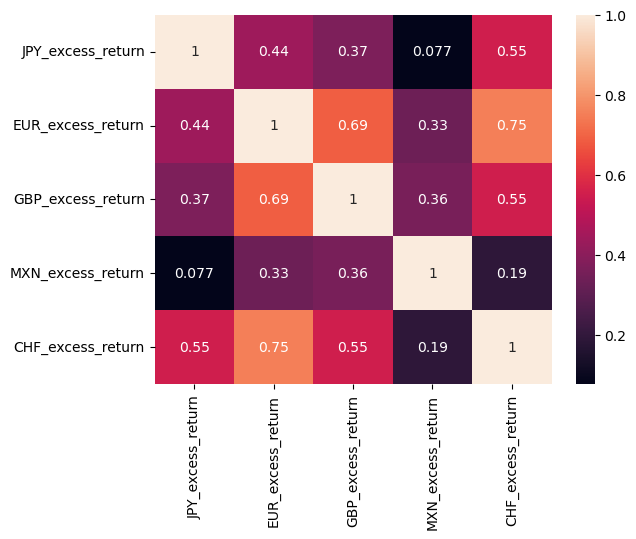

In [27]:
sns.heatmap(excess_returns_df.corr(), annot=True)

### 3.

As of `Dec 2017`, which of these currency trades has the most **carry**? 

Does this indicate high or low reeturns, assuming UIP?

In [31]:
path = "../data/fx_rf_data.xlsx"
risk_free_rate = pd.read_excel(path, sheet_name="risk-free rates", index_col=0)
exchange_rate = pd.read_excel(path, sheet_name="exchange rates", index_col=0)
risk_free_rate = risk_free_rate/252

dec_2017_date = "2017-12-31"
dec_2017_rf = risk_free_rate.loc[:dec_2017_date].iloc[-1]

usd_rate = dec_2017_rf["USD"]

carry = dec_2017_rf.drop("USD") - usd_rate
print("Carry as of Dec 2017:\n", carry)


max_carry_currency = carry.idxmax()
print("Currency with highest carry as of Dec 2017:", max_carry_currency)

Carry as of Dec 2017:
 JPY   -0.000059
EUR   -0.000073
GBP   -0.000029
MXN    0.000232
CHF   -0.000090
Name: 2017-12-29 00:00:00, dtype: float64
Currency with highest carry as of Dec 2017: MXN


*Answer* :  According to the UIP, currencies with higher interest rates should depreciate resulting in no systematic profit form carry trades like this (in practice usually is not true), i.e no higher returns, should implies a lower return on the FX 

### 4.

Calculate an **average currency factor** which is the equal-weighted average of the currency return series already calculated. Call this factor, $Z$.

Estimate the Linear Factor Decomposition of each of the currency trades on this factor, $\tilde{r}^z_t$. Report,
* annualized alphas
* betas
* r-squared values

In [ ]:
Z = excess_returns_df.mean(axis=1).rename("Z")

results_dict = {}
annual_factor = 252  

for c in excess_returns_df.columns:
    y = excess_returns_df[c].dropna()
    x = Z.loc[y.index]
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    alpha = model.params['const'] * annual_factor
    beta = model.params['Z']

    r2 = model.rsquared
    results_dict[c] = {"Annualized_alpha": alpha,
                       "Beta": beta,
                       "R_Squared": r2}

factor_decomposition = pd.DataFrame(results_dict).T
print(factor_decomposition)


                   Annualized_alpha      Beta  R_Squared
JPY_excess_return         -0.052224  0.832710   0.389112
EUR_excess_return         -0.020939  0.927855   0.695777
GBP_excess_return          0.000508  1.122580   0.639675
MXN_excess_return          0.069313  1.247766   0.401005
CHF_excess_return          0.003342  0.869089   0.594110


### 5.

Do your estimates seem in line with a factor pricing model for these trades where $\tilde{r}^z$ is the single factor? 

Explain your conclusion. Don't worry about small sample sizes.

*Answer* :  We can observe that the Annualized Alpha for almost all the factors are different that zero, therefore with this data at least the factor pricing model for these trades is not good, Z is not able to explain the excess of returns 

### 6. 

From the performance metrics of these currency trades, 
* Do you expect diversification is particularly useful or not? Be specific.
* Do you expect mean-variance optimization will do relatively well out of sample? Be specific.

*Answer* :  in this case, the correlation are relative low, except for EUR/CHF, which is 75%, with this, we expect that the inverst of the covariance matrix presents some instability due to the high correlation (as for example with FF factor). So diversification will not be so useful, but eventhough we can achive a ever performance using the asset, but for MV optimization could have some inestability out-of-sample due this correlation (EUR/CHF)

### 7.

Calculate the tangency weights for a portfolio of these currency trades. 

Report the performance metrics of `2.2` for this tangency portfolio.

In [37]:
def weights_tang(return_db, adj_factor = 12):
    sigma = (return_db.cov()*adj_factor)
    mu_excess = (return_db.mean()*adj_factor)
    vector = np.ones(len(mu_excess))
    w_tan = (np.linalg.inv(sigma) @ mu_excess )/(np.transpose(vector) @ np.linalg.inv(sigma) @ mu_excess)
    weights_db = pd.DataFrame({"w_tan": w_tan})
    weights_db.index = return_db.columns
    return weights_db


In [38]:
weights = weights_tang(excess_returns_df, adj_factor=252) 

print("Tangency Portfolio Weights:\n", weights)


Tangency Portfolio Weights:
                       w_tan
JPY_excess_return  2.662836
EUR_excess_return  4.282536
GBP_excess_return -0.683833
MXN_excess_return -1.338286
CHF_excess_return -3.923253


In [39]:
get_metric_returns(excess_returns_df @ weights, adj_factor=252, VaR_q=5)

,Mean,Volatility,Sharpe_Ratio,Skew,Excess Kurtosis,VaR,CVaR,Max Drawdown,Bottom,Peak,Recovery,Duration (days)
w_tan,-0.336854,0.290669,-1.158891,0.676095,3.818263,-0.029233,-0.038807,-0.947624,2024-06-21,2018-05-07,None,NaN


### 8.

Suppose you are a USD-based investor, but you want to short `1 JPY`, and use it to go long the equivalent amount of USD.

Calculate the excess return to this short-yen (SY) trade, denoted $\tilde{r}_{t+1}^{SY}$.

We're still examining `January 2018` through `August 2024`.

Report the first and last three values of the timeseries of excess returns.

In [ ]:
print("First three values of SY excess returns:")
display((-excess_returns_df[["JPY_excess_return"]]).head(3))
print("Last three values of SY excess returns:")
display((-excess_returns_df[["JPY_excess_return"]]).tail(3))


First three values of SY excess returns:


,JPY_excess_return
date,
2018-01-02,-0.003321
2018-01-03,0.002080
2018-01-04,0.002196


Last three values of SY excess returns:


,JPY_excess_return
date,
2024-08-28,0.004522
2024-08-29,0.002950
2024-08-30,0.008323


### 9.

Report the performance statistics requested in `2.2` for this short-yen trade. 

Also, what date is the min and max return for this trade?

In [43]:
get_metric_returns(-excess_returns_df[["JPY_excess_return"]], adj_factor=252, VaR_q=5)

,Mean,Volatility,Sharpe_Ratio,Skew,Excess Kurtosis,VaR,CVaR,Max Drawdown,Bottom,Peak,Recovery,Duration (days)
JPY_excess_return,0.056823,0.084743,0.670533,-0.520696,6.526638,-0.008115,-0.012977,-0.146787,2023-01-13,2024-07-10,2023-08-16,215


In [45]:
min_date = (-excess_returns_df[["JPY_excess_return"]]).idxmin()
max_date = (-excess_returns_df[["JPY_excess_return"]]).idxmax()

In [46]:
print("Short-Yen Minimum Return Date:", min_date, "Value:", sy.loc[min_date])
print("Short-Yen Maximum Return Date:", max_date, "Value:", sy.loc[max_date])

Short-Yen Minimum Return Date: JPY_excess_return   2022-12-20
dtype: datetime64[ns] Value: date
2022-12-20   -0.039119
Name: SY_excess_return, dtype: float64
Short-Yen Maximum Return Date: JPY_excess_return   2020-03-10
dtype: datetime64[ns] Value: date
2020-03-10    0.030964
Name: SY_excess_return, dtype: float64


***